In [80]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

In [323]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', 'SPY'] #, 'TSLA', 'GOOG', 'TQQQ', 'BA', 'GLD', 'STOR', 'APTS', 'KO']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2015-05-05'
end_date = '2020-05-05'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)["Adj Close"]

In [84]:
panel_data.head()

Symbols,AAPL,MSFT,SPY,TSLA,GOOG,TQQQ,BA,GLD,STOR,APTS,KO
Date,,,,,,,,,,,
2015-05-05,28.812078,42.697773,187.458649,46.590000,530.799988,17.916271,124.801361,114.419998,16.020565,7.275141,34.018425
2015-05-06,28.631145,41.513718,186.686905,46.085999,524.219971,17.533730,123.957626,114.360001,15.966619,7.220747,33.943283
2015-05-07,28.808235,41.890469,187.431702,47.360001,530.700012,17.834774,124.353134,113.419998,16.197798,7.349932,33.976673
2015-05-08,29.351009,42.832325,189.899445,47.321999,538.219971,18.488424,127.842300,113.970001,16.621620,7.336334,34.210423
2015-05-11,29.052025,42.491455,188.993118,47.897999,535.700012,18.285509,128.220215,113.529999,16.544561,7.417925,34.177025


In [61]:
df_array = panel_data["AAPL"].values.reshape(-1, 1)
print(df_array.shape)
df_array[:5]

(1260, 1)


array([[28.81207848],
       [28.63114548],
       [28.80823517],
       [29.35100937],
       [29.05202484]])

In [39]:
dataset_train = np.array(df_array[:int(df_array.shape[0]*0.8)])
dataset_test = np.array(df_array[int(df_array.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1008, 1)
(302, 1)


In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.21515934],
       [0.2100435 ],
       [0.21505067],
       [0.2303975 ],
       [0.22194378]])

In [41]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.61070731],
       [0.61140193],
       [0.61515286],
       [0.60320566],
       [0.61584726]])

In [42]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [43]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.21515934, 0.2100435 , 0.21505067, 0.2303975 , 0.22194378,
        0.21901743, 0.21992782, 0.23904619, 0.23787569, 0.24710963,
        0.24632937, 0.24626444, 0.25491318, 0.26239153, 0.24340302,
        0.25914015, 0.25744918, 0.24769498, 0.24938574, 0.24561399,
        0.24665457, 0.24171232, 0.23709527, 0.23156789, 0.22909682,
        0.23859086, 0.23670525, 0.22747111, 0.22584544, 0.23026732,
        0.22831646, 0.23208805, 0.22376456, 0.23033236, 0.22656066,
        0.23358395, 0.22961714, 0.22473983, 0.21030355, 0.21615613,
        0.22376456, 0.22272398, 0.21986278, 0.21784694, 0.19755808,
        0.18130091, 0.20217496, 0.21765182, 0.21732657, 0.2251951 ]])

In [44]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.61070731, 0.61140193, 0.61515286, 0.60320566, 0.61584726,
        0.62196   , 0.61973712, 0.61272181, 0.59869086, 0.60153868,
        0.64314517, 0.65710676, 0.66266349, 0.67669443, 0.69329535,
        0.70649297, 0.69614339, 0.70746543, 0.75560111, 0.72753933,
        0.71149389, 0.69794928, 0.70961864, 0.71135507, 0.71989875,
        0.72885921, 0.74816903, 0.75740733, 0.7597687 , 0.76886797,
        0.79040067, 0.78623308, 0.79401257, 0.78241279, 0.7818571 ,
        0.78435761, 0.78449664, 0.81144714, 0.81651785, 0.82117167,
        0.84166223, 0.83943956, 0.82638119, 0.81957405, 0.82172737,
        0.79435999, 0.86277827, 0.85326212, 0.87132185, 0.8486084 ]])

In [45]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Building Model

In [46]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [47]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
if(not os.path.exists('stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('stock_prediction.h5')

Epoch 1/50
30/30 [==============================] - 3s 98ms/step - loss: 0.0395
Epoch 2/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0055
Epoch 3/50
30/30 [==============================] - 3s 111ms/step - loss: 0.0041
Epoch 4/50
30/30 [==============================] - 3s 96ms/step - loss: 0.0041
Epoch 5/50
30/30 [==============================] - 4s 138ms/step - loss: 0.0037
Epoch 6/50
30/30 [==============================] - 3s 99ms/step - loss: 0.0038
Epoch 7/50
30/30 [==============================] - 3s 97ms/step - loss: 0.0032
Epoch 8/50
30/30 [==============================] - 3s 115ms/step - loss: 0.0039
Epoch 9/50
30/30 [==============================] - 4s 117ms/step - loss: 0.0037
Epoch 10/50
30/30 [==============================] - 4s 117ms/step - loss: 0.0027
Epoch 11/50
30/30 [==============================] - 3s 100ms/step - loss: 0.0028
Epoch 12/50
30/30 [==============================] - 3s 111ms/step - loss: 0.0028
Epoch 13/50
30/30 [===========

In [49]:
model = load_model('stock_prediction.h5')

# Visualizing Results

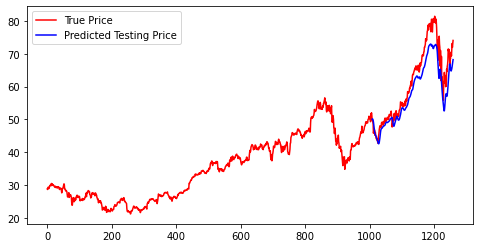

In [51]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df_array, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

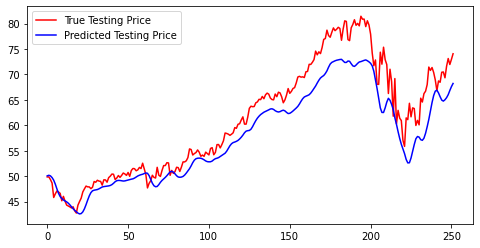

In [52]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [53]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data = np.expand_dims(x, axis=0)
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[68.21406, 101.907906, 122.8393, 130.71365, 134.31589, 136.0811, 137.06573, 137.65881, 138.03705, 138.28653, 138.45479, 138.57, 138.64977, 138.70546, 138.74481, 138.77278, 138.7929, 138.80753, 138.81834, 138.8265, 138.8328, 138.83778, 138.84178, 138.84517, 138.84807, 138.85068, 138.85307, 138.85529, 138.85744, 138.85953, 138.86156, 138.86345, 138.8653, 138.867, 138.86865, 138.87021, 138.87183, 138.87372, 138.87627, 138.87982, 138.8847, 138.89095, 138.8989, 138.90765, 138.91615, 138.92168, 138.92142, 138.91182, 138.88925, 138.8529, 138.79936, 138.76044, 138.7519, 138.74953, 138.74849, 138.74796, 138.74765, 138.74748, 138.74739, 138.74728, 138.74721, 138.74721, 138.74721, 138.7472, 138.7472, 138.7472, 138.7472, 138.74722, 138.74722, 138.74722, 138.74725, 138.74724, 138.74725, 138.74725, 138.74725, 138.74728, 138.7473, 138.74733, 138.74738, 138.74738, 138.74739, 138.7474, 138.7474, 138.74742, 138.74747, 138.74748, 138.74748, 138.74751, 138.74754, 138.74754, 138.74754, 138.74756, 138.74759

# Q-Learning Build Up

In [324]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

In [325]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
def get_state(t, lookback, is_cov_matrix = True, is_raw_time_series = False):
    
    def preprocess_state(state):
        return state

    assert lookback <= t

    decision_making_state = panel_data.iloc[t-lookback:t]
    decision_making_state = np.log(decision_making_state).dropna() # added np.log to obtain returns and removed pct_change()

    if is_cov_matrix:
        x = decision_making_state.cov()
        return x
    else:
        if is_raw_time_series:
            decision_making_state = panel_data.iloc[t-lookback:t]
        return preprocess_state(decision_making_state)

In [326]:
N_ASSETS = len(tickers)
agent = Agent(N_ASSETS)

In [327]:
window_size = 360
episode_count = 50
batch_size = 32
rebalance_period = 30

In [328]:
def get_reward(action, action_t, reward_t, alpha = 0.01):

    def local_portfolio(returns, weights):
        weights = np.array(weights)
        rets = returns.mean() # * 252
        covs = returns.cov() # * 252
        P_ret = np.sum(rets * weights)
        P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
        P_sharpe = P_ret / P_vol
        return np.array([P_ret, P_vol, P_sharpe])

    data_period = panel_data[action_t:reward_t]
    weights = action
    returns = np.log(data_period).dropna() # changed pct_change to log returns

    sharpe = local_portfolio(returns, weights)[-1]
    sharpe = np.array([sharpe] * len(panel_data.columns))
    rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

    return np.dot(returns, weights), rew

In [329]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))

    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()
    alpha = model.params[0]
    beta = model.params[1]

    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

Episode 0/50 epsilon 1.0


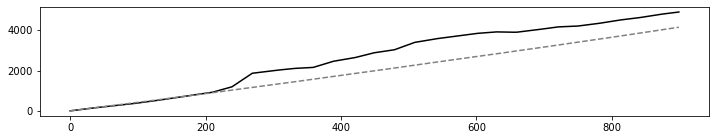

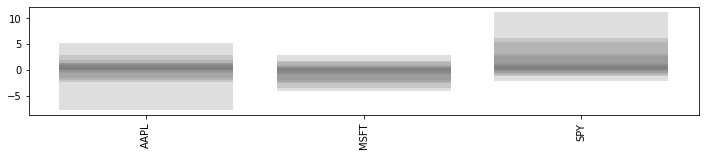

Episode 1/50 epsilon 1.0


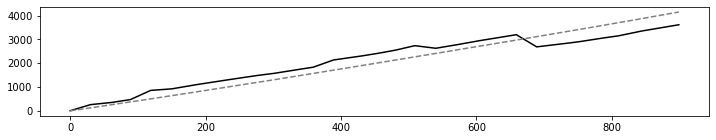

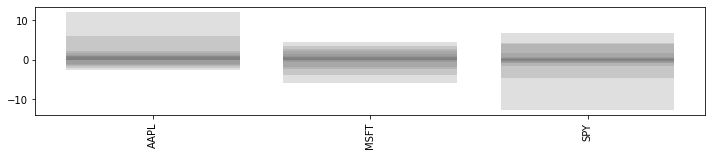

Episode 2/50 epsilon 0.99


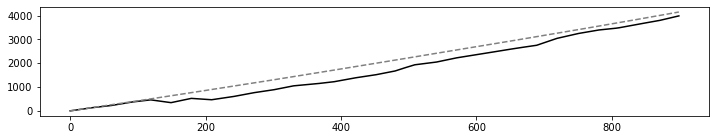

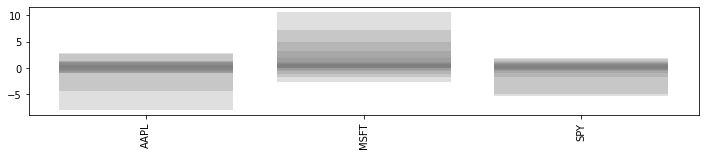

Episode 3/50 epsilon 0.9801


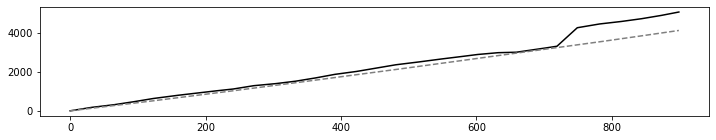

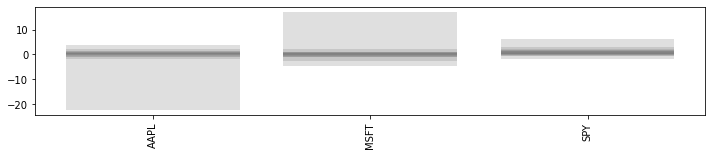

Episode 4/50 epsilon 0.9702989999999999


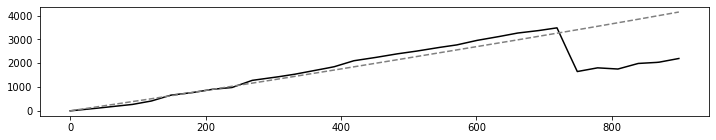

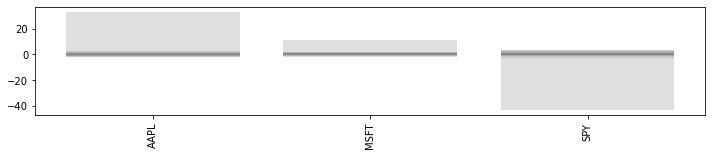

Episode 5/50 epsilon 0.96059601


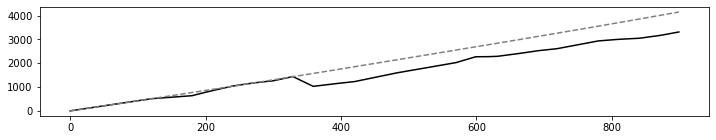

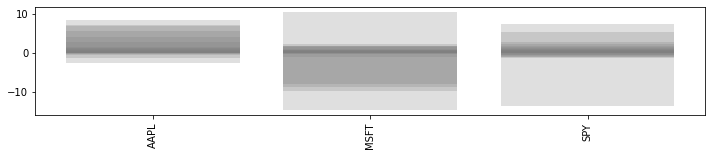

Episode 6/50 epsilon 0.9509900498999999


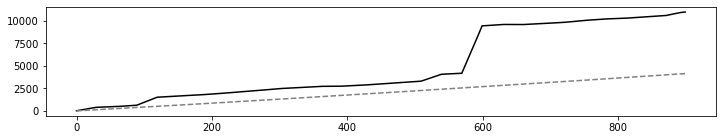

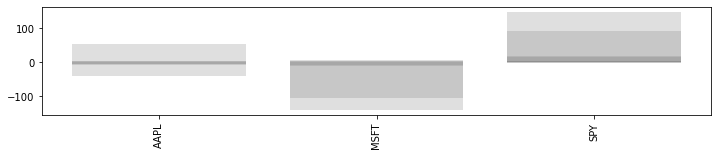

Episode 7/50 epsilon 0.9414801494009999


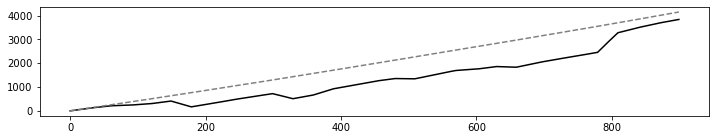

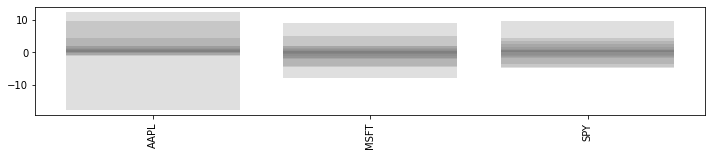

Episode 8/50 epsilon 0.9320653479069899


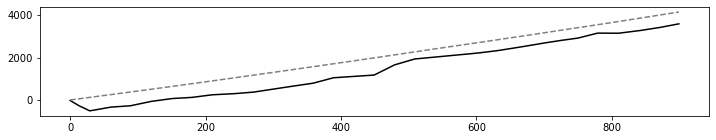

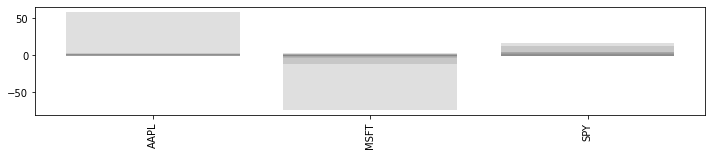

Episode 9/50 epsilon 0.92274469442792


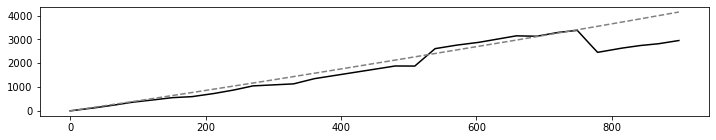

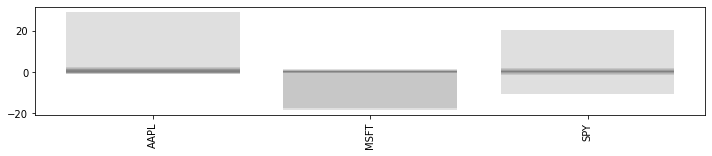

Episode 10/50 epsilon 0.9135172474836407


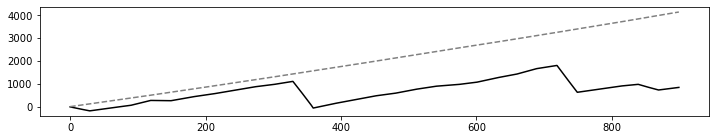

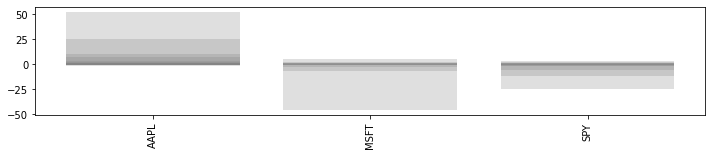

Episode 11/50 epsilon 0.9043820750088043


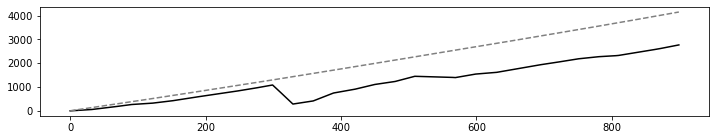

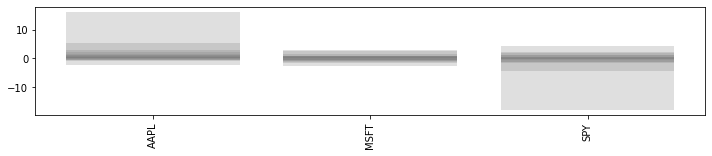

Episode 12/50 epsilon 0.8953382542587163


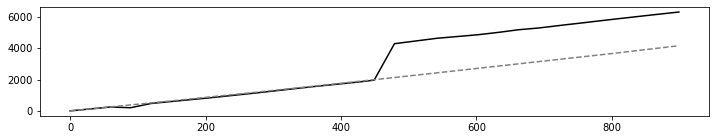

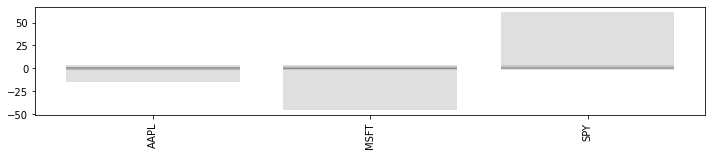

Episode 13/50 epsilon 0.8863848717161291


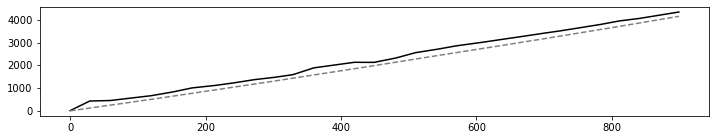

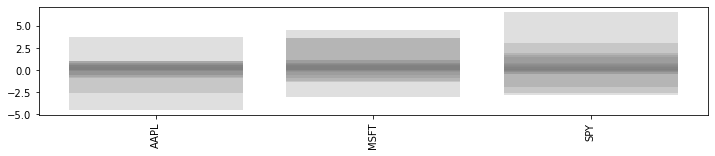

Episode 14/50 epsilon 0.8775210229989678


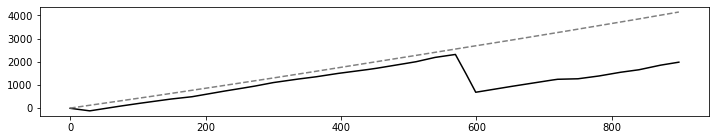

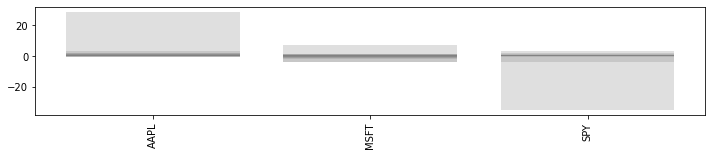

Episode 15/50 epsilon 0.8687458127689781


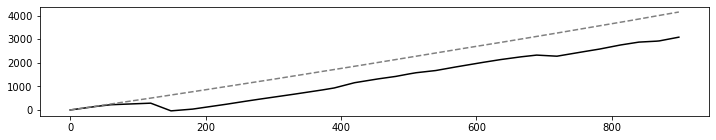

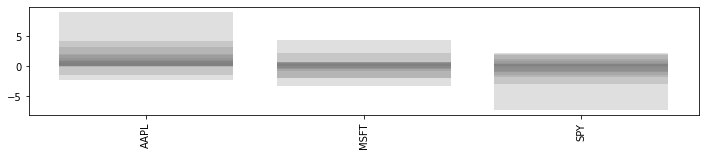

Episode 16/50 epsilon 0.8600583546412883


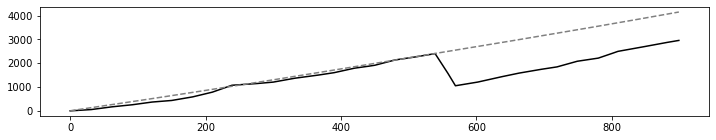

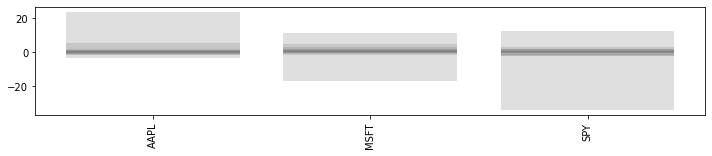

Episode 17/50 epsilon 0.8600583546412883


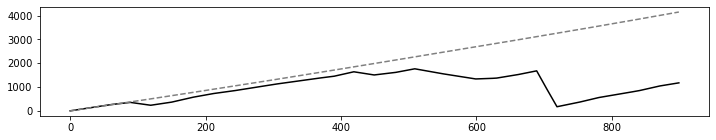

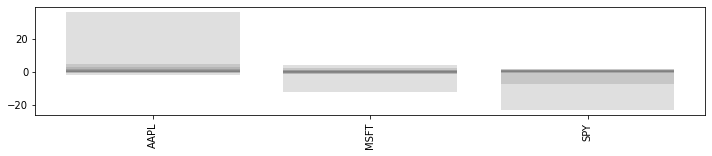

Episode 18/50 epsilon 0.8514577710948754


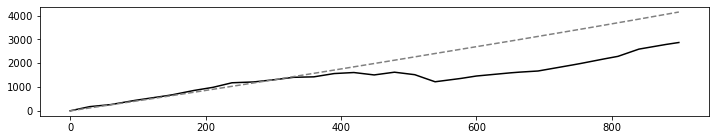

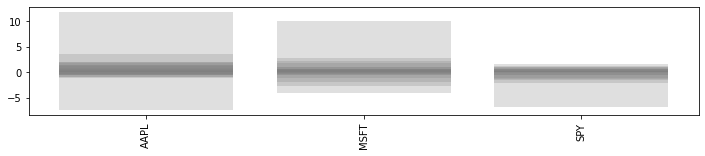

Episode 19/50 epsilon 0.8429431933839266


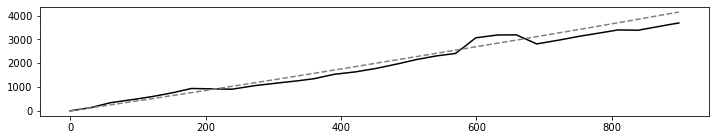

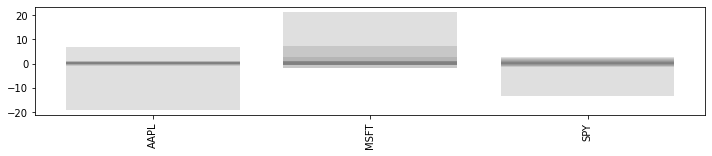

Episode 20/50 epsilon 0.8345137614500874


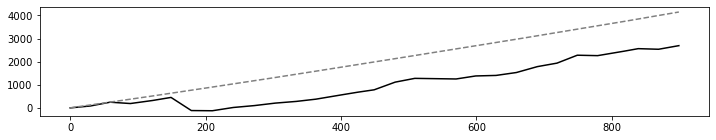

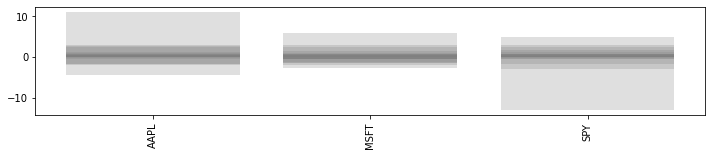

Episode 21/50 epsilon 0.8261686238355865


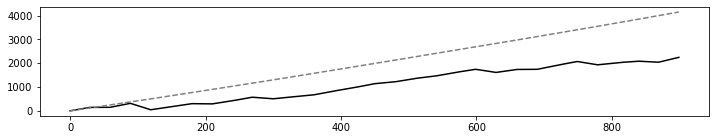

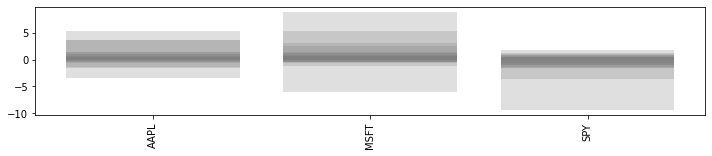

Episode 22/50 epsilon 0.8179069375972307


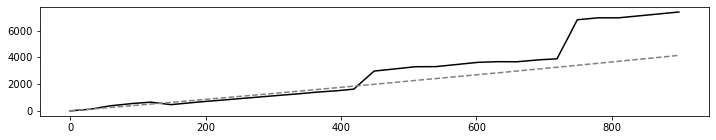

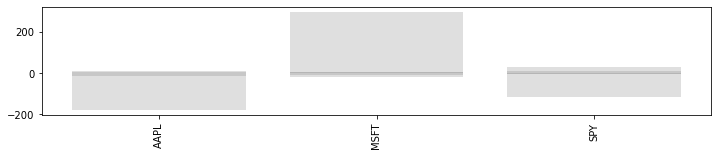

Episode 23/50 epsilon 0.8097278682212583


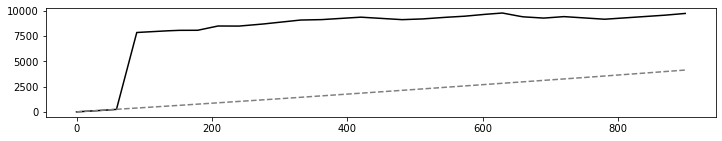

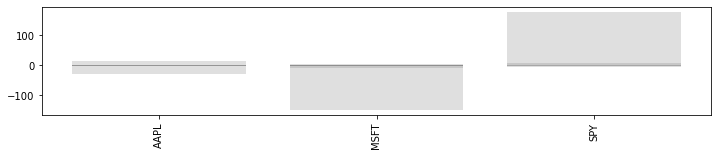

Episode 24/50 epsilon 0.8016305895390458


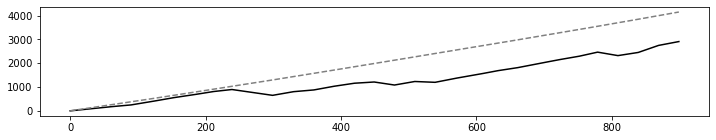

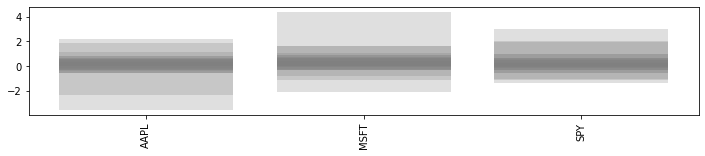

Episode 25/50 epsilon 0.7936142836436553


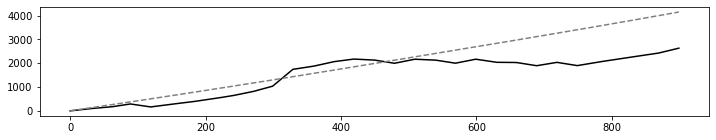

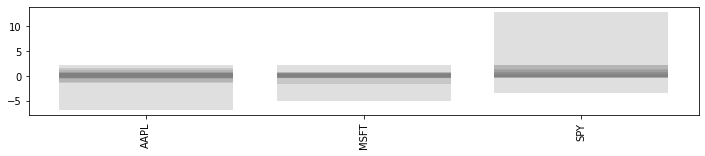

Episode 26/50 epsilon 0.7856781408072188


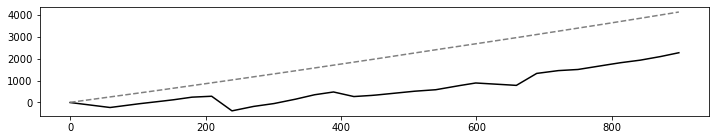

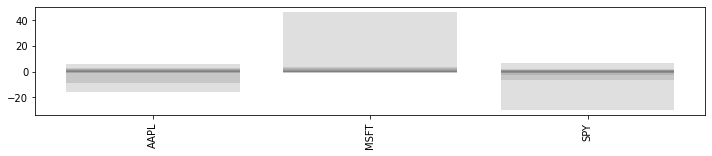

Episode 27/50 epsilon 0.7778213593991465


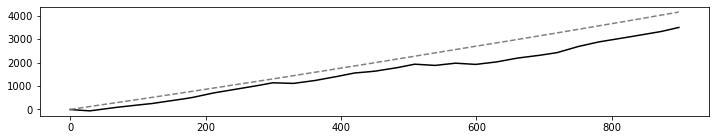

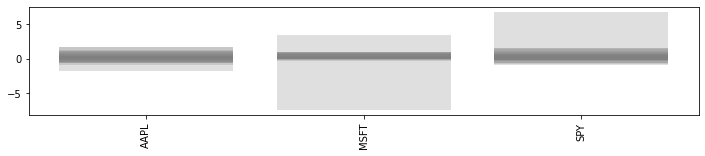

Episode 28/50 epsilon 0.7700431458051551


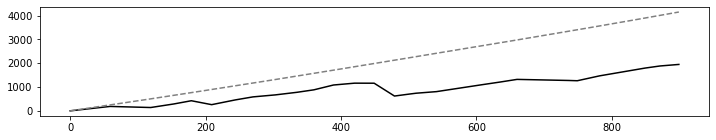

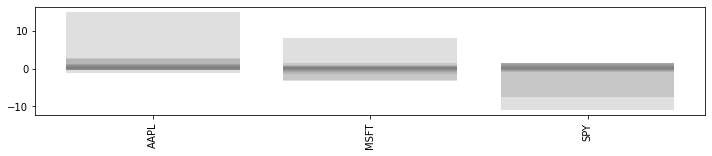

Episode 29/50 epsilon 0.7623427143471035


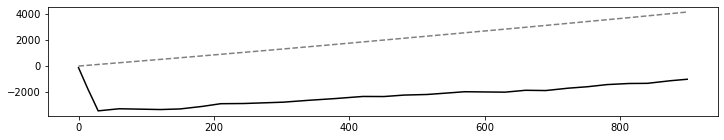

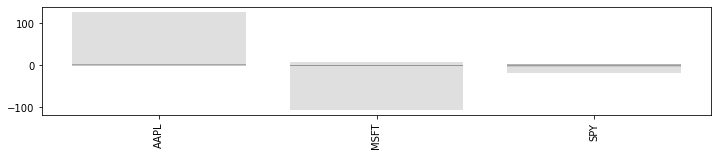

Episode 30/50 epsilon 0.7547192872036325


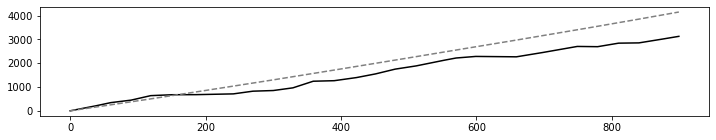

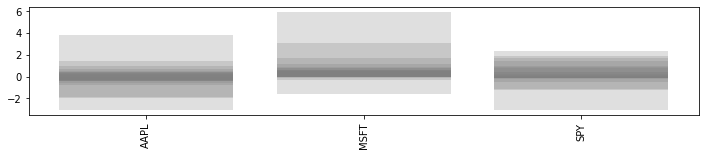

Episode 31/50 epsilon 0.7471720943315961


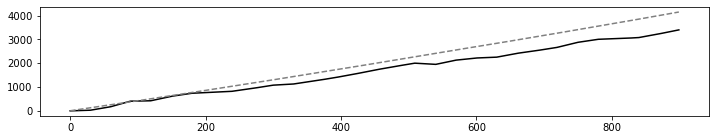

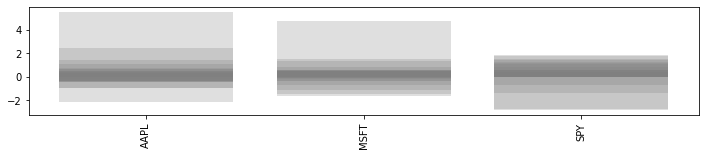

Episode 32/50 epsilon 0.7397003733882802


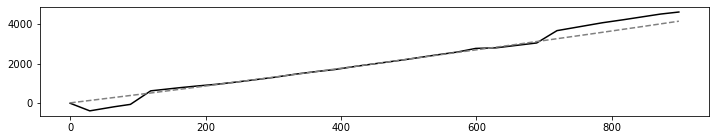

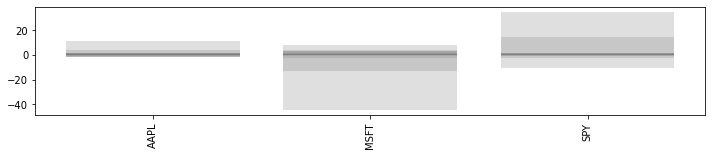

Episode 33/50 epsilon 0.7397003733882802


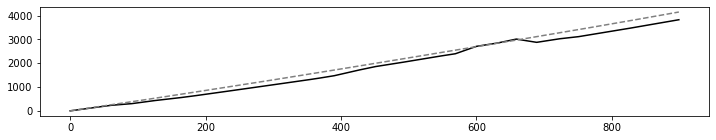

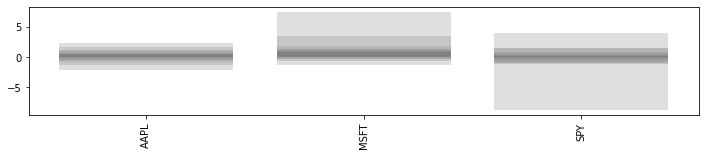

Episode 34/50 epsilon 0.7323033696543974


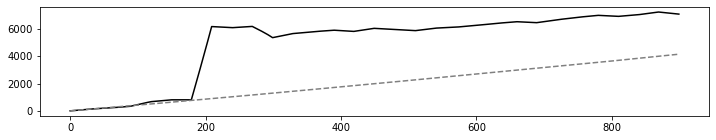

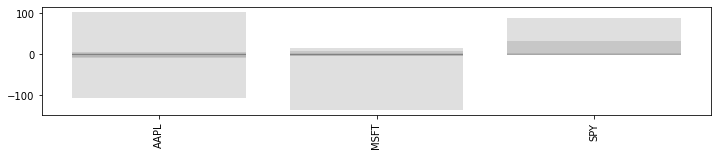

Episode 35/50 epsilon 0.7249803359578534


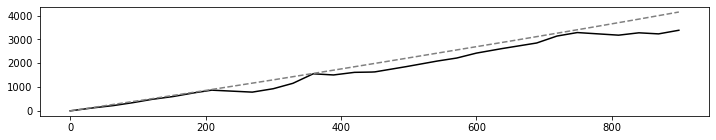

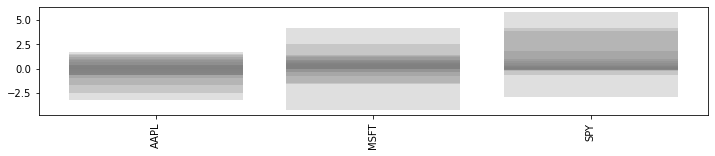

Episode 36/50 epsilon 0.7177305325982748


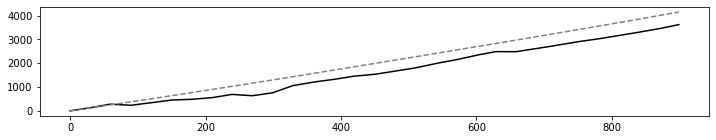

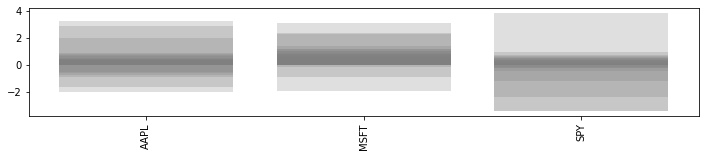

Episode 37/50 epsilon 0.7105532272722921


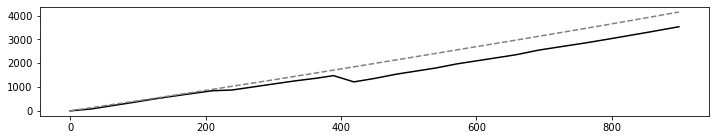

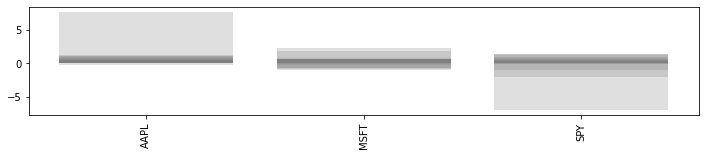

Episode 38/50 epsilon 0.7034476949995692


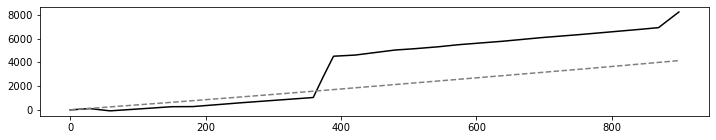

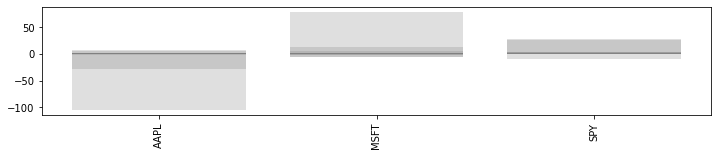

Episode 39/50 epsilon 0.6964132180495735


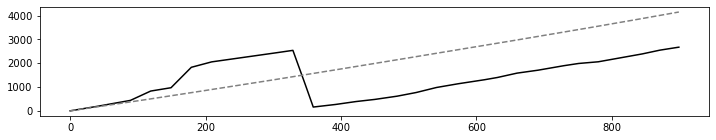

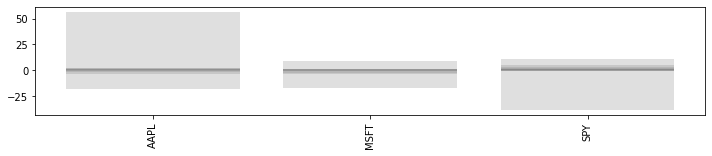

Episode 40/50 epsilon 0.6894490858690777


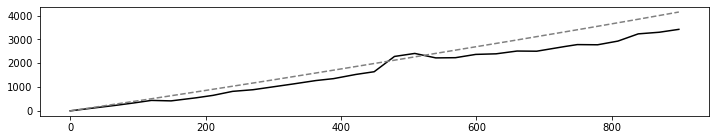

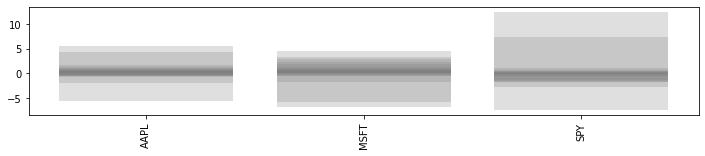

Episode 41/50 epsilon 0.682554595010387


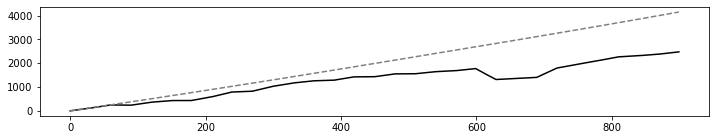

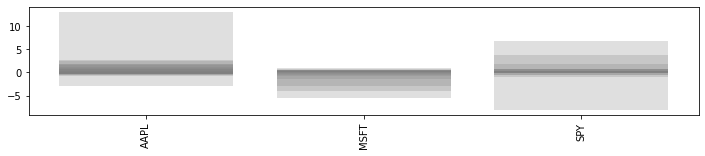

Episode 42/50 epsilon 0.6757290490602831


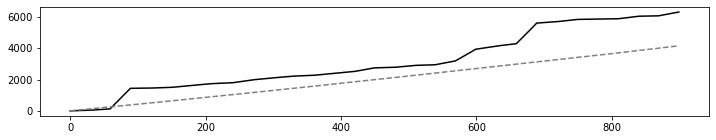

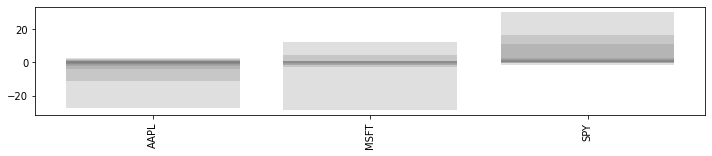

Episode 43/50 epsilon 0.6689717585696803


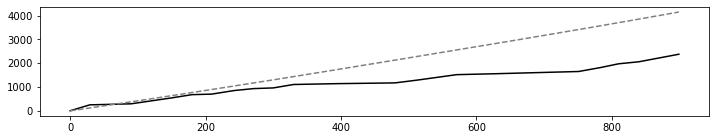

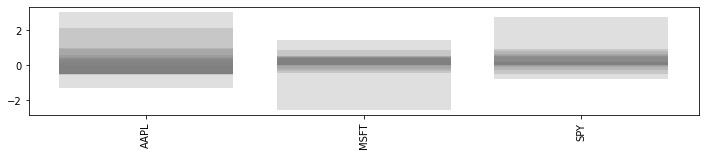

Episode 44/50 epsilon 0.6622820409839835


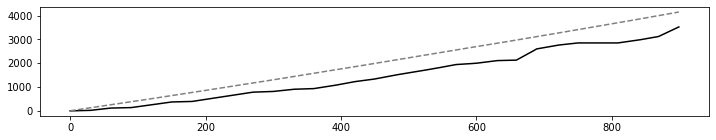

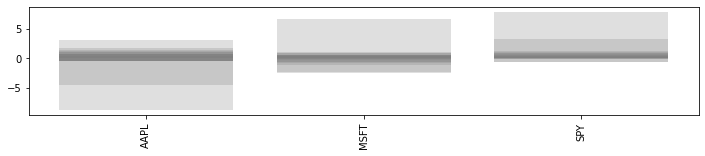

Episode 45/50 epsilon 0.6556592205741436


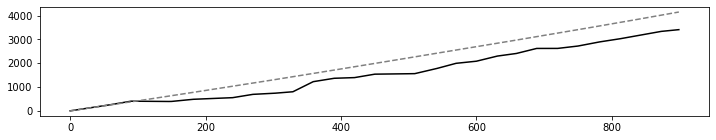

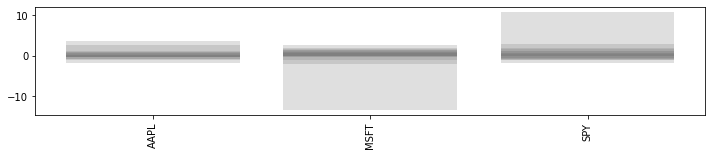

Episode 46/50 epsilon 0.6491026283684022


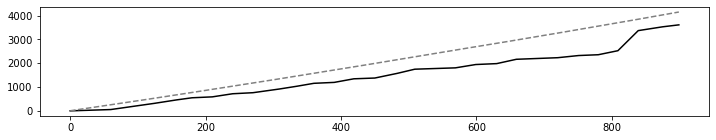

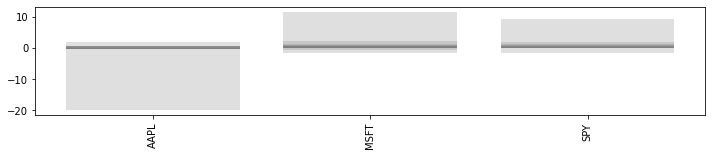

Episode 47/50 epsilon 0.6426116020847181


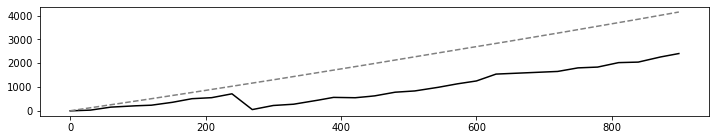

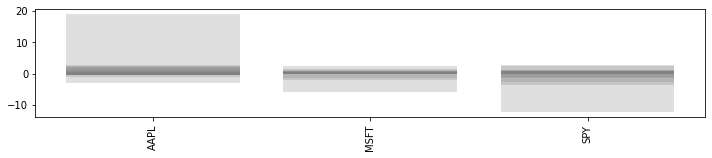

Episode 48/50 epsilon 0.6361854860638709


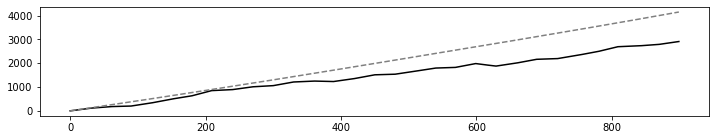

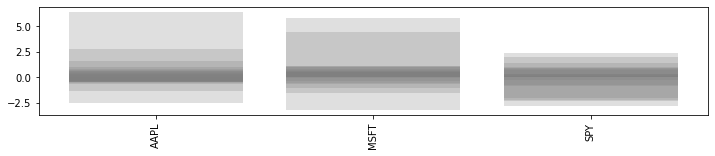

Episode 49/50 epsilon 0.6361854860638709


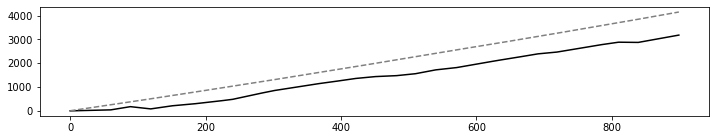

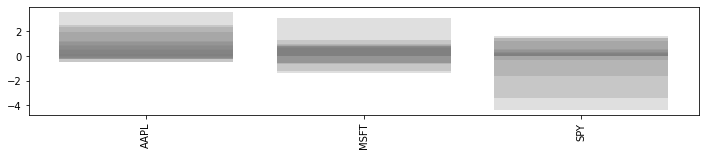

In [330]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(panel_data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])

        weighted_returns, reward = get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), panel_data.columns, rotation='vertical')
    plt.show()
    

# Evaluating agent

In [331]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(panel_data), rebalance_period):

    date1 = t-rebalance_period
    s_ = get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [332]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

In [333]:
np.array(result_rl_vis)

array([1.54151393, 1.54467098, 1.54543447, 1.54727941, 1.54822402,
       1.54402167, 1.54284143, 1.54081046, 1.54099376, 1.53909519,
       1.54676228, 1.54128514, 1.54226821, 1.52680932, 1.51167587,
       1.50838784, 1.5102529 , 1.51213657, 1.51123322, 1.52074341,
       1.5188586 , 1.52108053, 1.51489986, 1.52351225, 1.5222097 ,
       1.52149827, 1.52154349, 1.52145367, 1.51754236, 1.52129326,
       1.53085727, 1.53016103, 1.52656694, 1.51683697, 1.51314814,
       1.5121927 , 1.51418654, 1.5122406 , 1.51706737, 1.51762705,
       1.51527911, 1.53544061, 1.54291668, 1.54036234, 1.54573991,
       1.54486447, 1.54506617, 1.54603714, 1.55056768, 1.54635434,
       1.54784316, 1.5471635 , 1.55873451, 1.55774127, 1.55797938,
       1.55770232, 1.55755686, 1.56014863, 1.5655055 , 1.56130573,
       1.61062624, 1.60765937, 1.60738509, 1.60946538, 1.60595464,
       1.60577097, 1.60627067, 1.61060833, 1.60695774, 1.60153208,
       1.60065054, 1.61181158, 1.60750659, 1.61702742, 1.61119

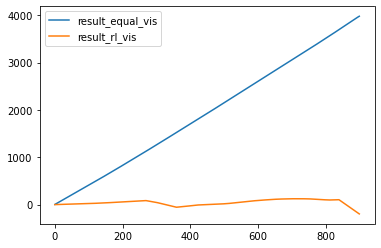

In [295]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'result_equal_vis')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'result_rl_vis')
plt.legend()
plt.show()

In [321]:
EQUAL = print_stats(result_equal_vis, result_equal_vis)
RL_AGENT = print_stats(result_rl_vis, result_equal_vis)

print(f'EQUAL:\nRET: {EQUAL[0]}, VOL: {EQUAL[1]}, SR: {EQUAL[2]}, ALPHA: {EQUAL[3]}, BETA: {EQUAL[4]}') # try weighting against a complete spy portfolio not equally weighted
print(f'RL AGENT:\nRET: {RL_AGENT[0]}, VOL: {RL_AGENT[1]}, SR: {RL_AGENT[2]}, ALPHA: {RL_AGENT[3]}, BETA: {RL_AGENT[4]}') 


EQUAL:
RET: 4.4206, VOL: 0.195, SR: 360.3468, ALPHA: 0.0, BETA: 1.0
RL AGENT:
RET: -0.2182, VOL: 1.4262, SR: -2.4328, ALPHA: 12.9203, BETA: -2.9721


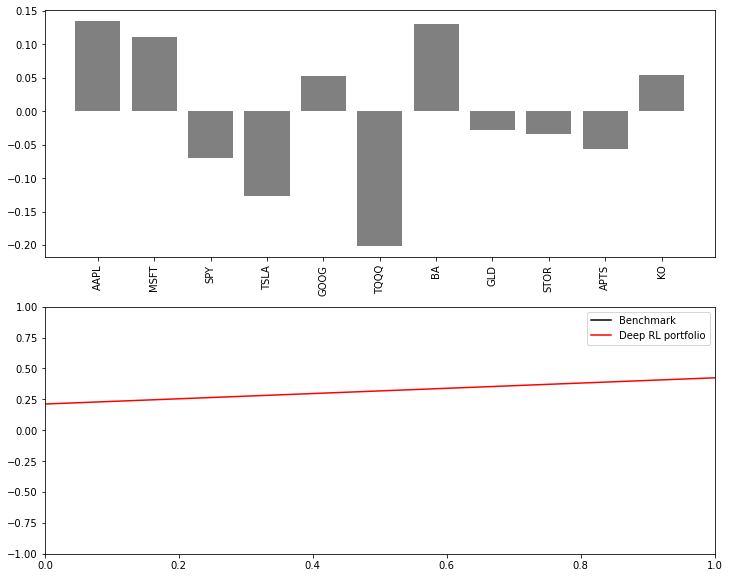

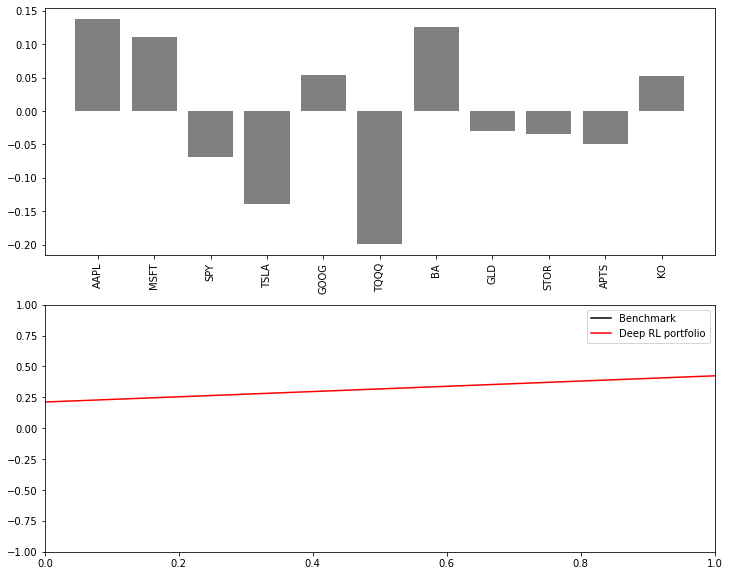

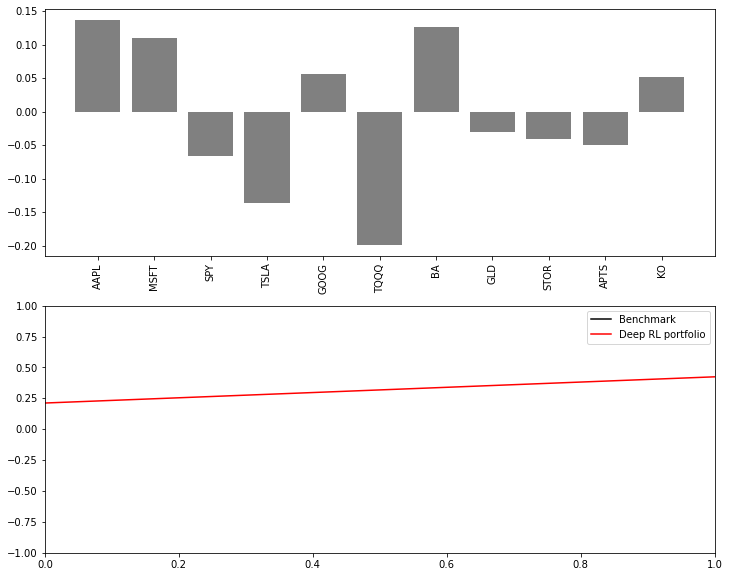

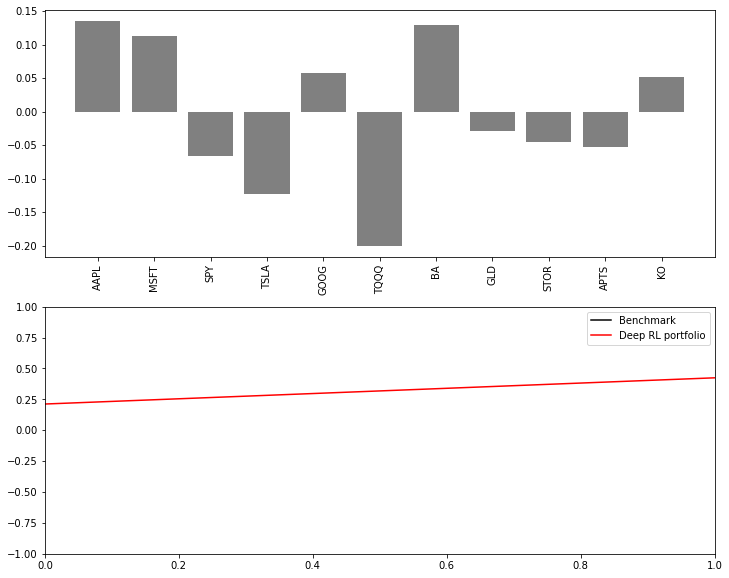

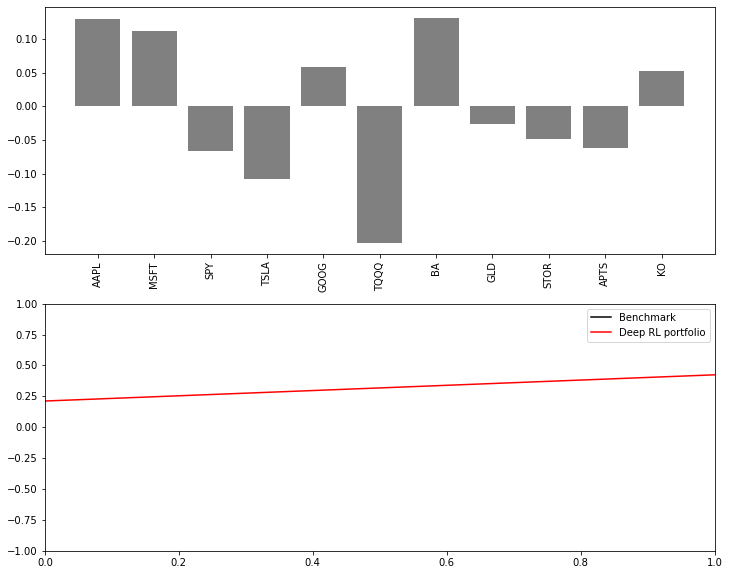

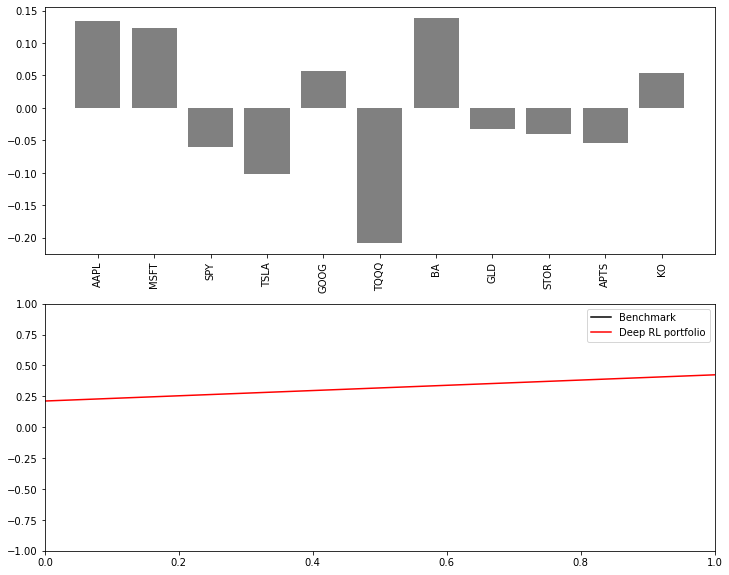

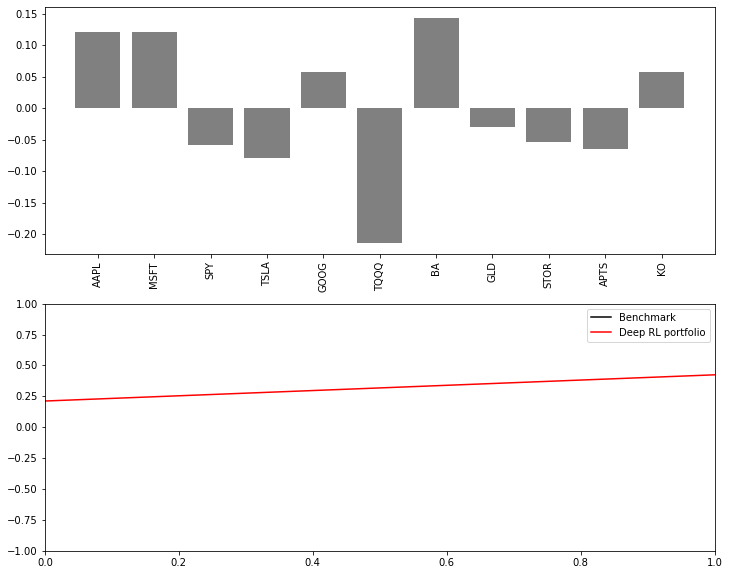

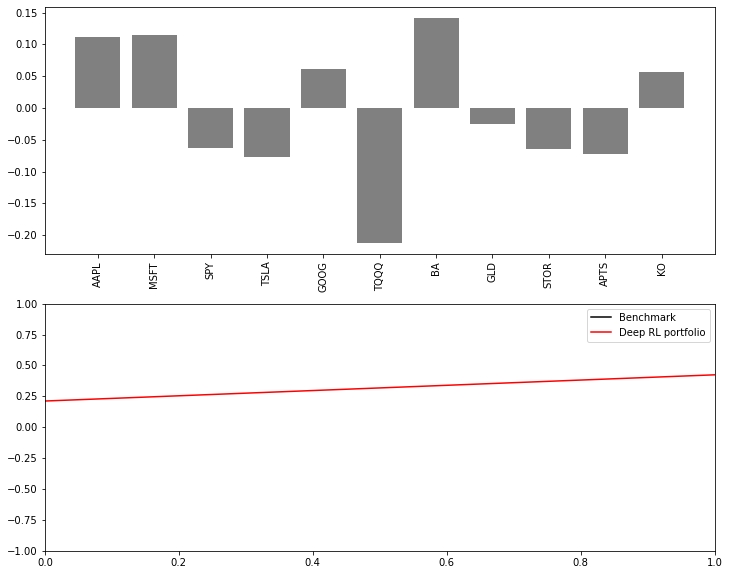

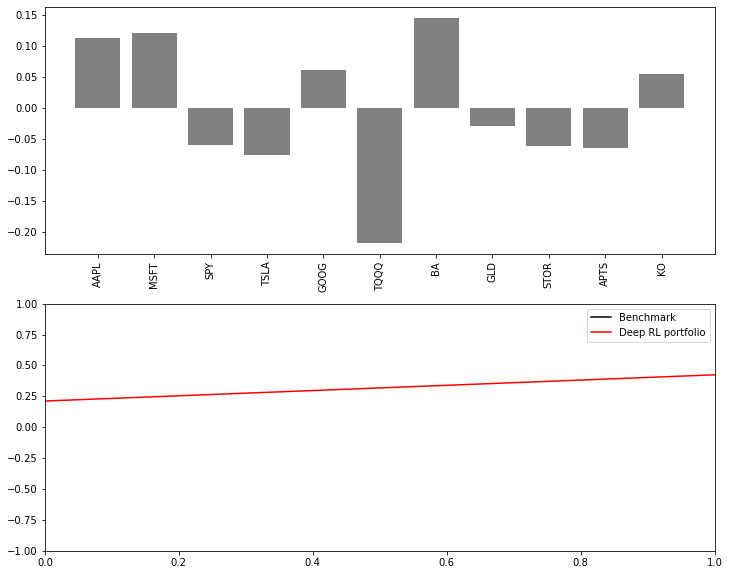

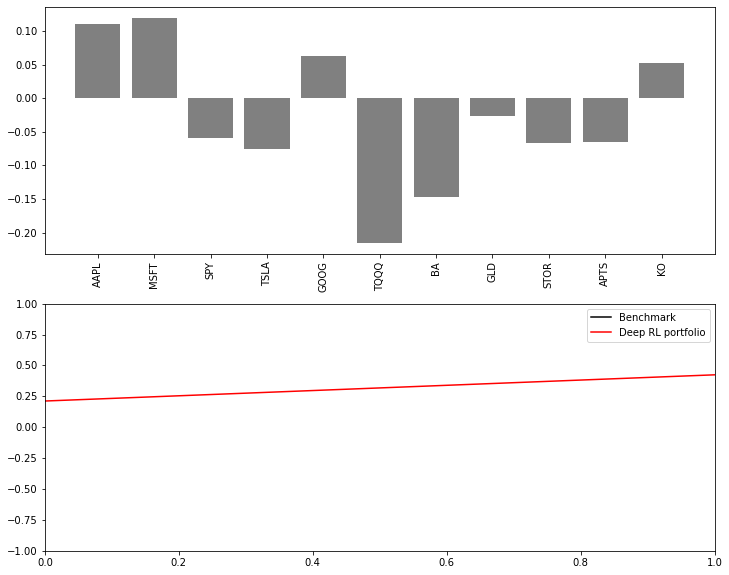

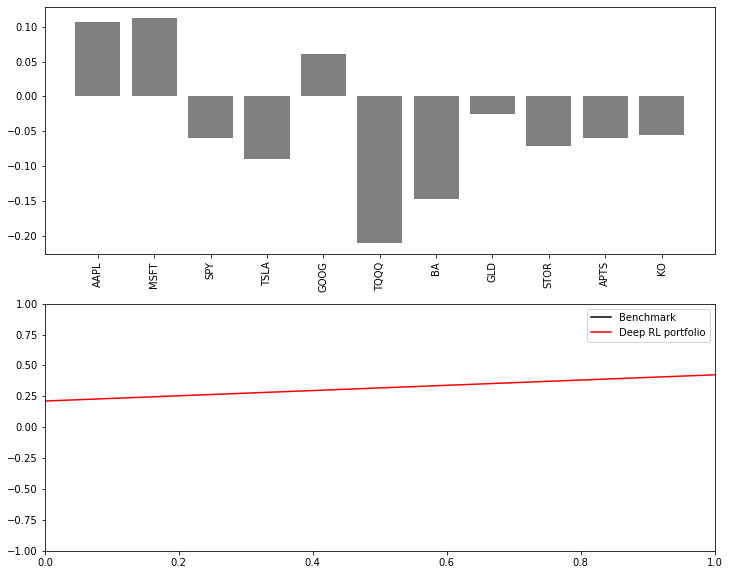

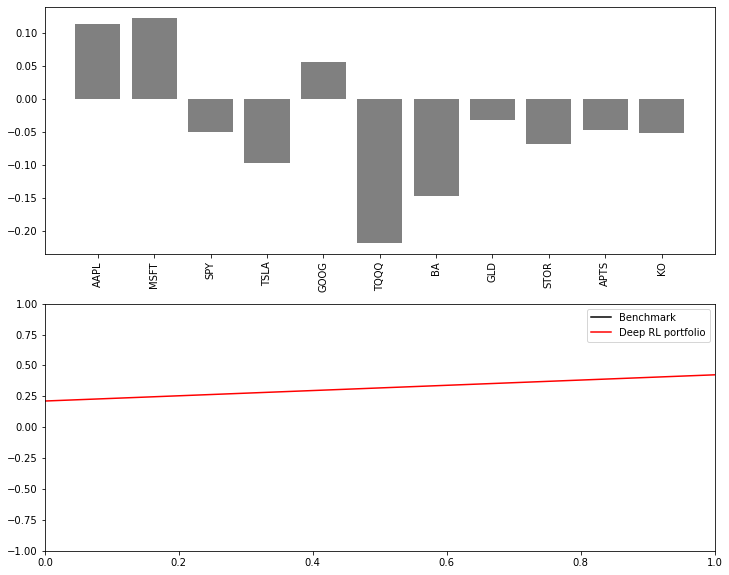

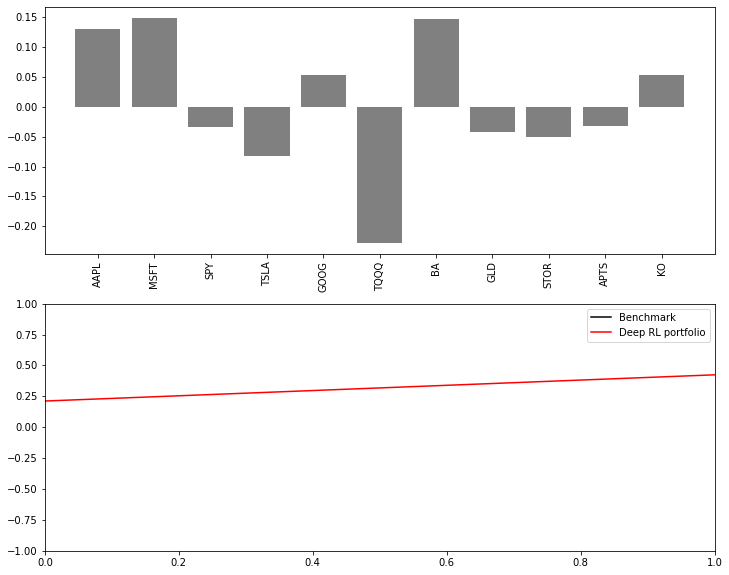

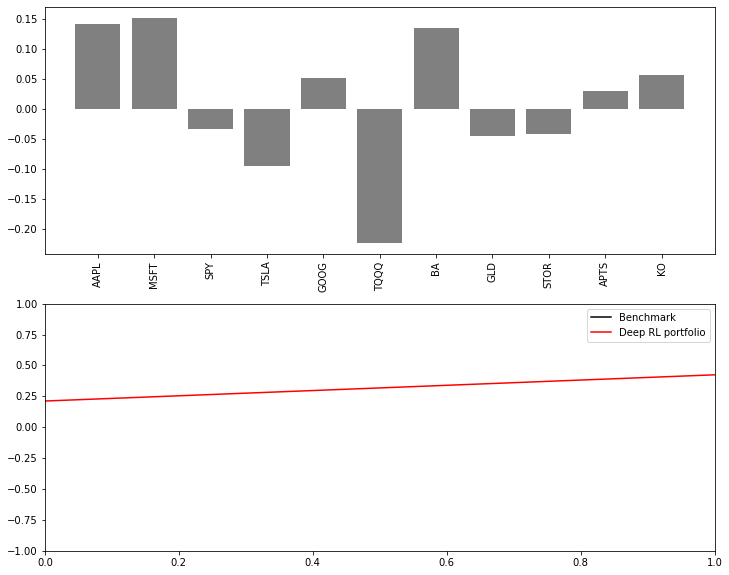

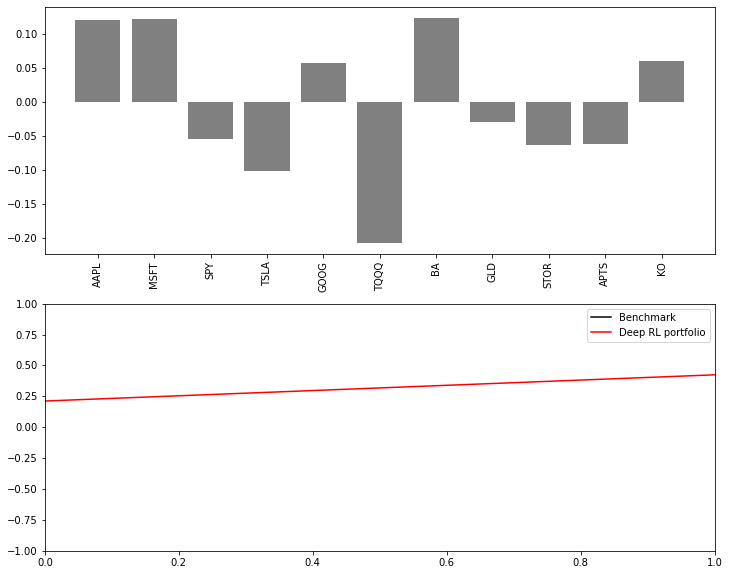

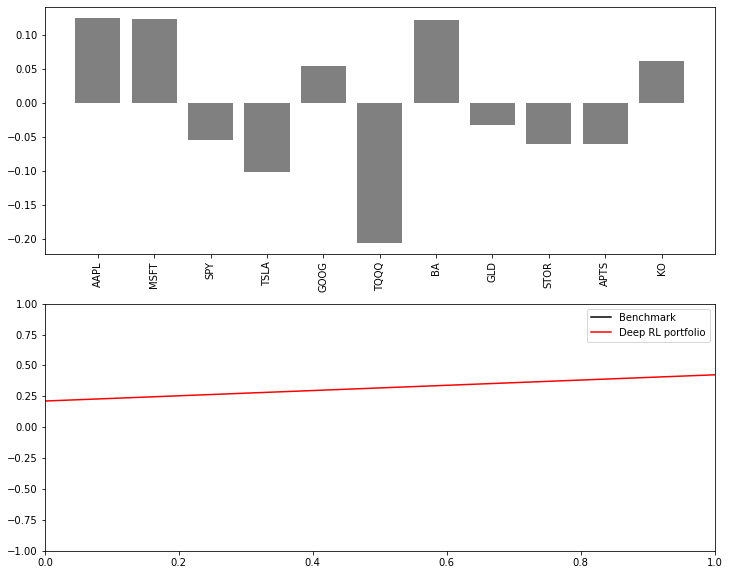

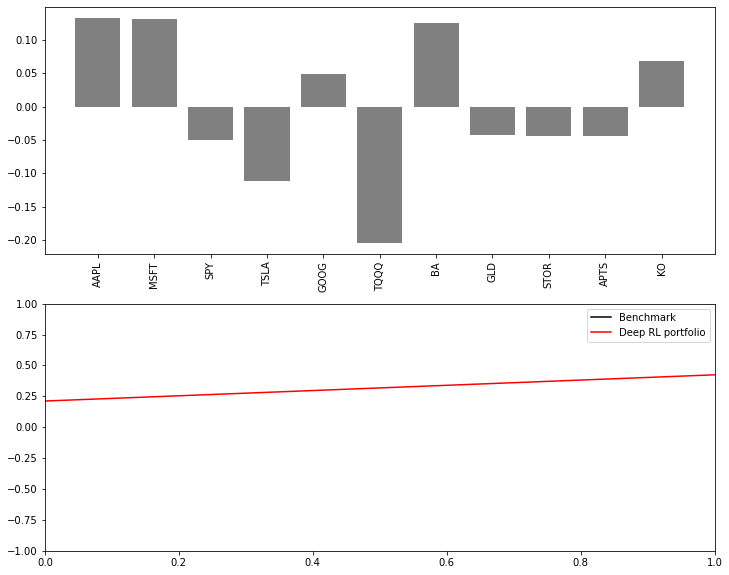

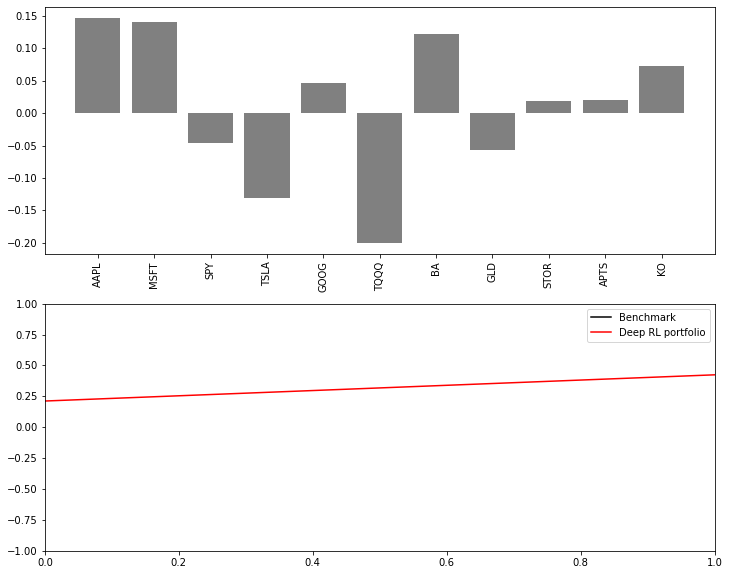

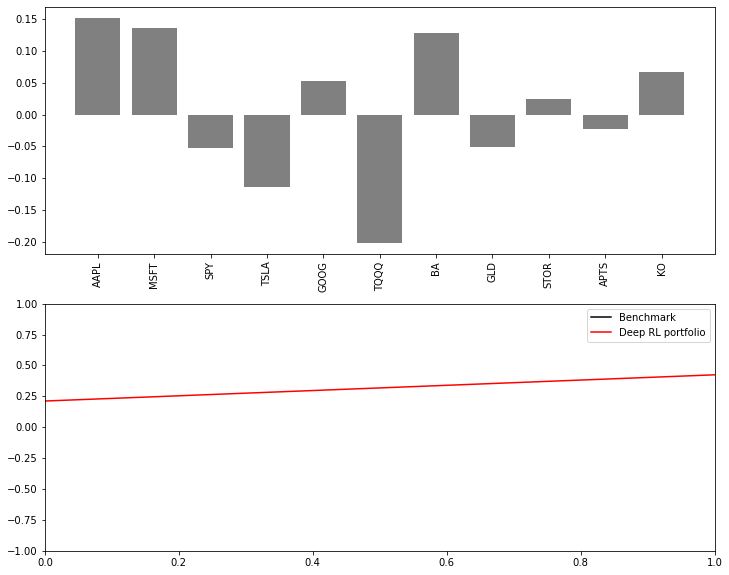

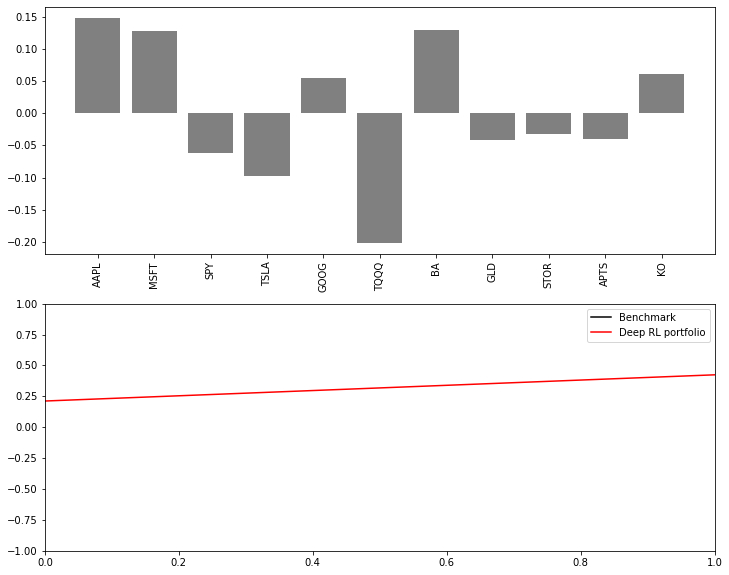

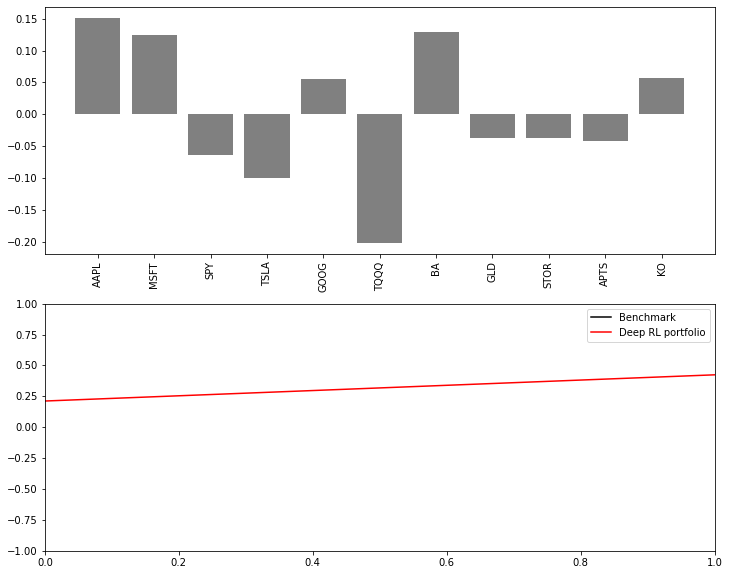

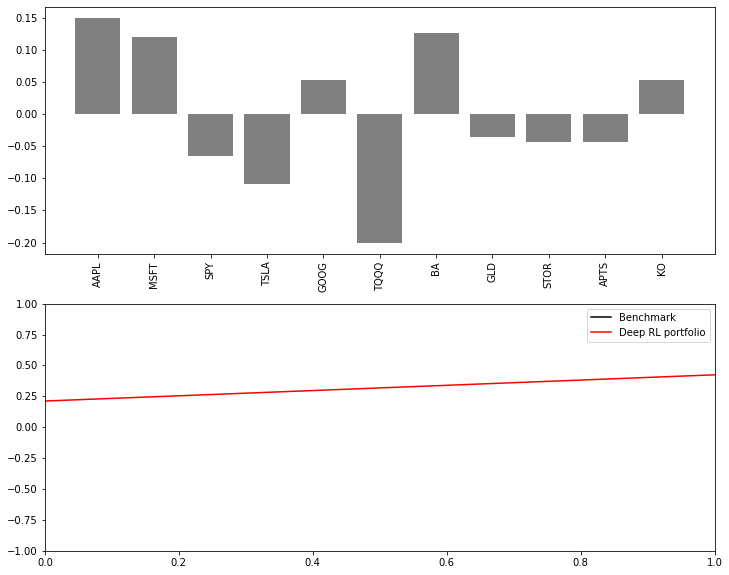

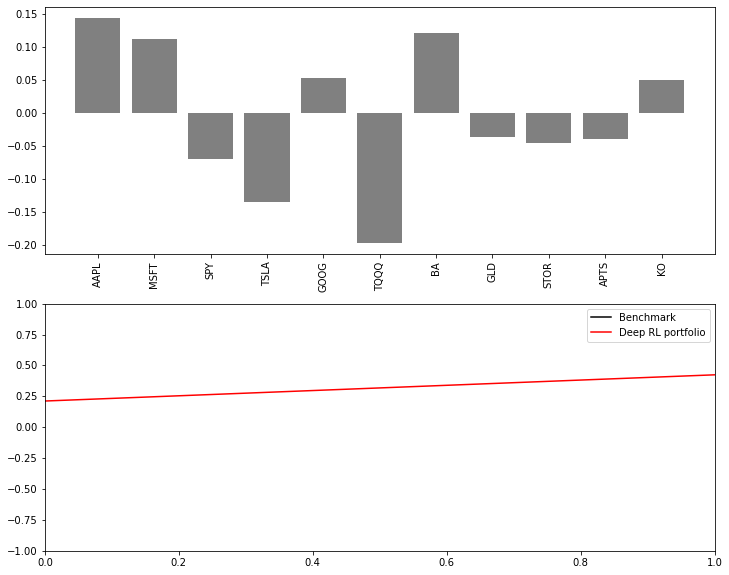

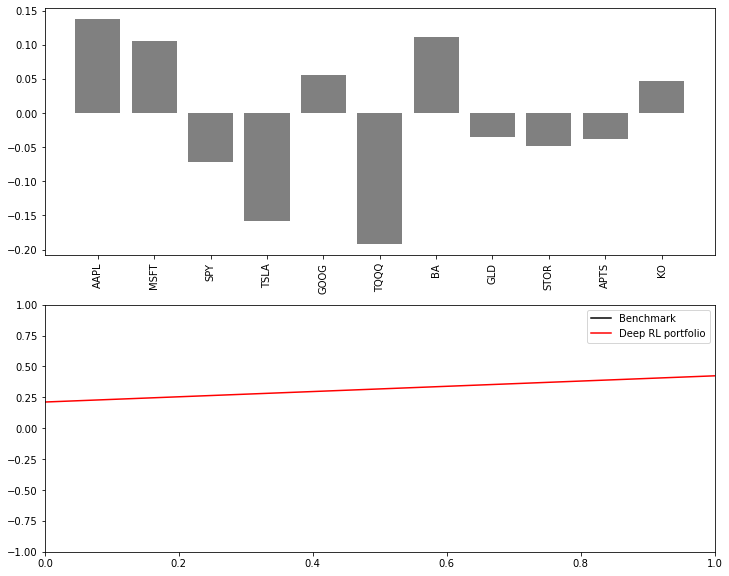

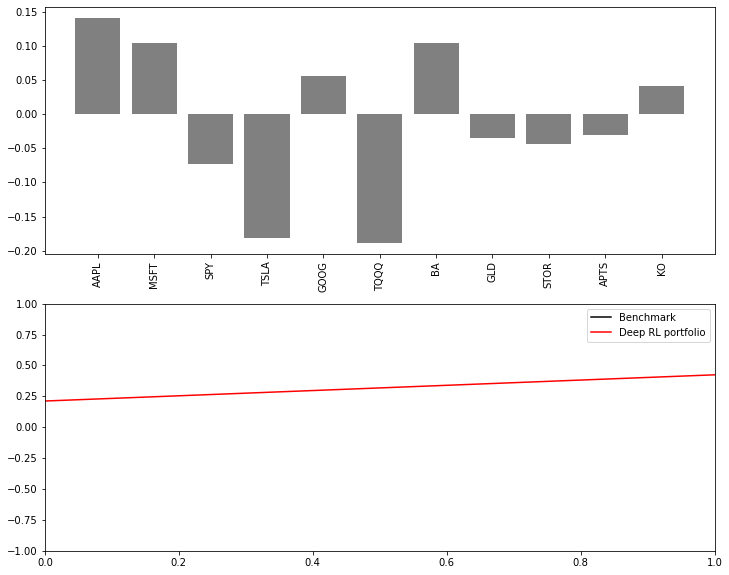

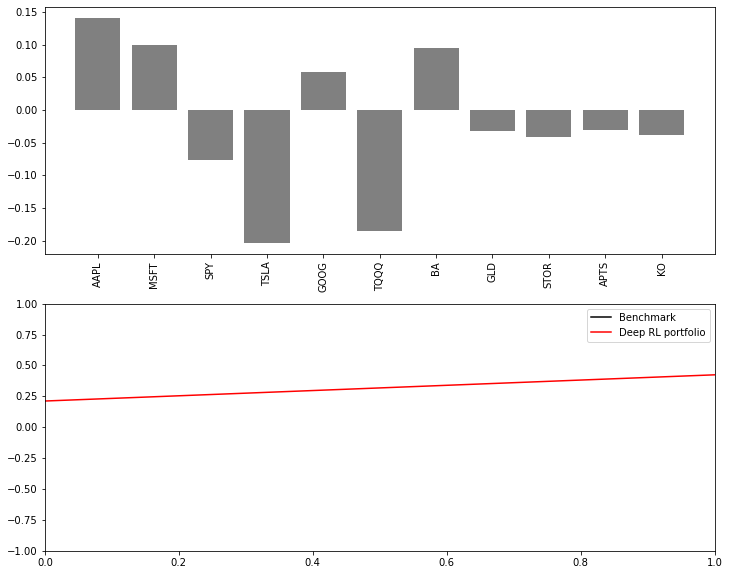

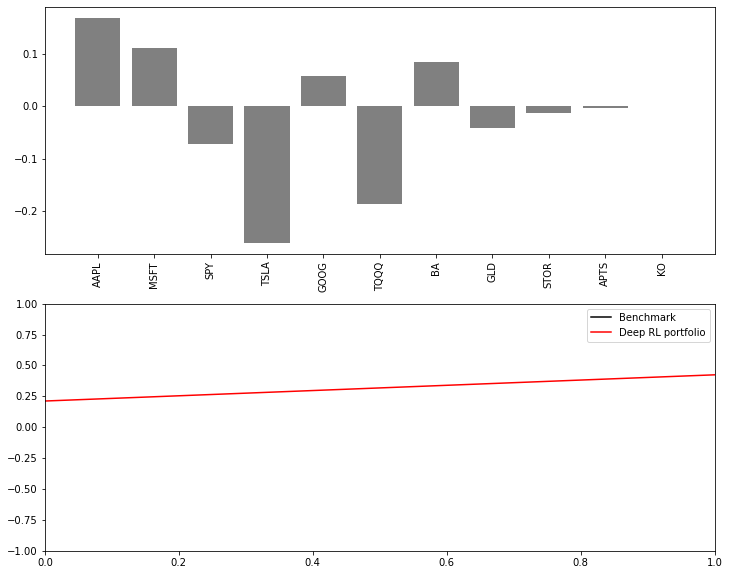

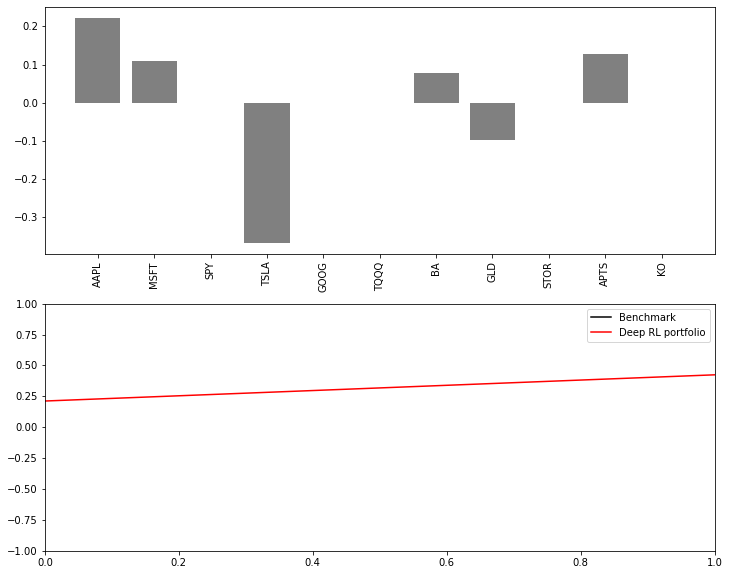

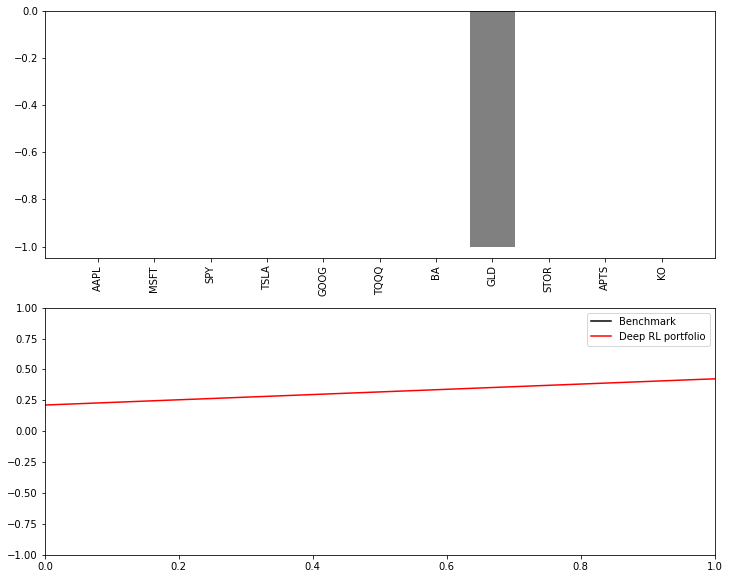

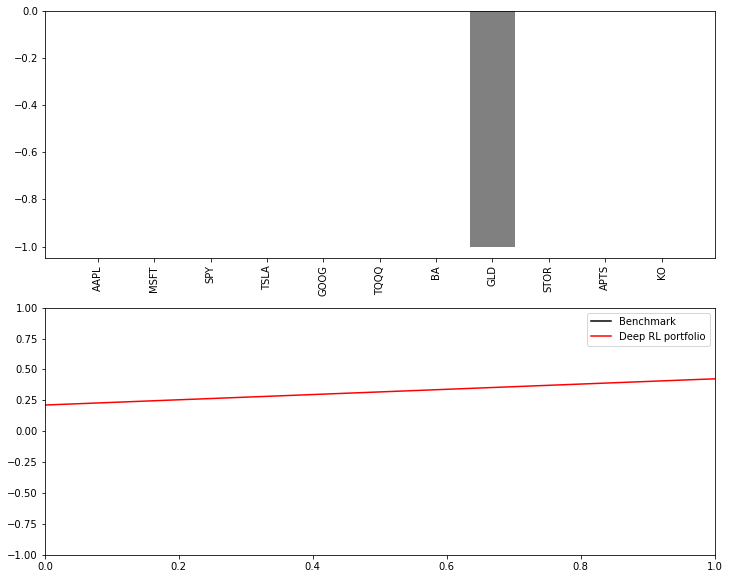

In [303]:
plot_results(result_equal, 
             result_rl, 
             actions_rl, 
             N_ASSETS,
             panel_data.columns, 
             'Deep RL portfolio', './images_test1/rl/', 'series')

In [ ]:
# change elu to lstm
# change linear Dense layer to tanh or sigmoid
# change stock portfolio
# Try Long Only